In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

from typing import Tuple, List

%matplotlib inline

In [2]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [3]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


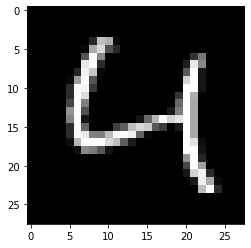

torch.Size([32, 1, 28, 28])
torch.Size([32])


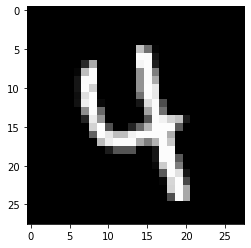

torch.Size([32, 1, 28, 28])
torch.Size([32])


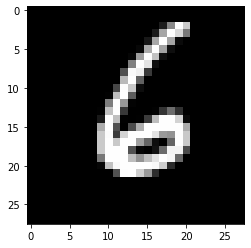

torch.Size([32, 1, 28, 28])
torch.Size([32])


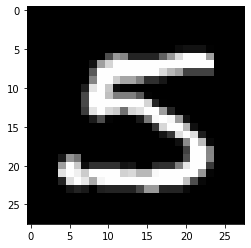

torch.Size([32, 1, 28, 28])
torch.Size([32])


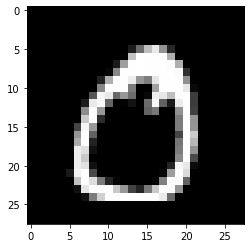

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [9]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],*self.out_size))

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [11]:
device = torch.device('cpu')

In [12]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)
ae

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [13]:
x, y = valid_dl.dataset[30]

In [14]:
print(x.shape)
print(x.requires_grad)

torch.Size([1, 28, 28])
False


In [15]:
with torch.no_grad():
    out = ae(x)

In [16]:
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
False


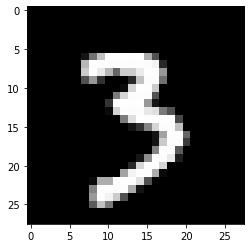

In [18]:
plt.imshow(x[0], cmap='gray')

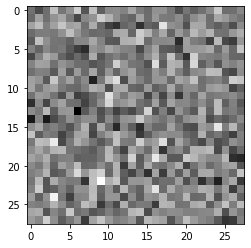

In [19]:
plt.imshow(out[0],cmap='gray')

In [20]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    device = model.parameters().__next__().device
    ae.eval()

    actual_list = [x for i, (x, y) in enumerate(valid_dl.dataset) if i < ELEM_NUM]
    
    with torch.no_grad():
        actuals_batch = torch.cat(actual_list).unsqueeze(1)
        reconst_batch = ae(actuals_batch.to(device)).cpu().unsqueeze(1)
    
    ae.train()
    
    grid_elems = [*actuals_batch, *reconst_batch]

    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1, pad_value =1)
  
    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

In [21]:
def show_summary_1(valid_dl:DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    device = model.parameters().__next__().device
    
    ae.eval()
    
    actuals, reconst = [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            actuals.append(x)
            reconst.append(ae(x.to(device).cpu()))
            if i == ELEM_NUM-1: break
    
    ae.train()
    
    grid_elems = [*actuals, *reconst]
    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1,pad_value=1)

    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

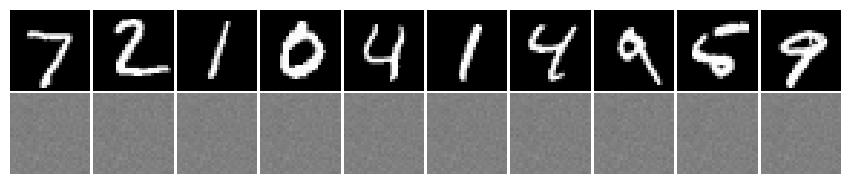

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.05 s


In [22]:
%%time
show_summary(valid_dl,ae)

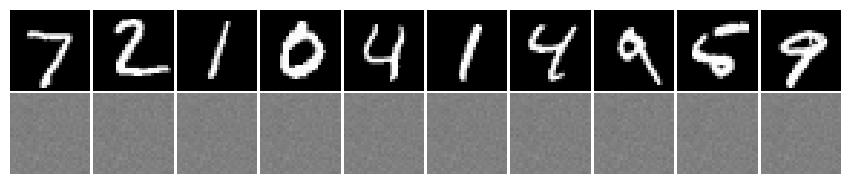

CPU times: user 273 ms, sys: 11.8 ms, total: 285 ms
Wall time: 143 ms


In [23]:
%%time
show_summary_1(valid_dl,ae)

In [70]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [71]:
seed_everything()

In [75]:
def init_params(m:nn.Module):
    for p in m.parameters():
        if p.dim==2:
            nn.init.uniform_(p)
        if p.dim==1:
            nn.init.zeros_(p)

In [76]:
ae.apply(init_params)
#ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

epoch 0 | iter 0 | cost 0.0097


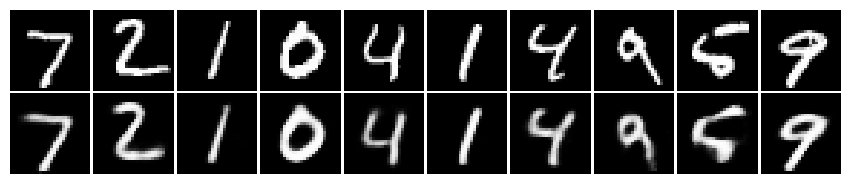

epoch 0 | iter 10 | cost 0.0092
epoch 0 | iter 20 | cost 0.0080
epoch 0 | iter 30 | cost 0.0101
epoch 0 | iter 40 | cost 0.0084
epoch 0 | iter 50 | cost 0.0111


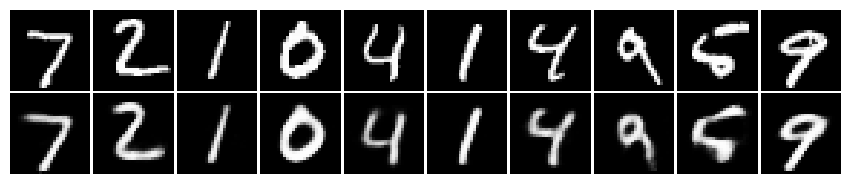

epoch 0 | iter 60 | cost 0.0103
epoch 0 | iter 70 | cost 0.0101
epoch 0 | iter 80 | cost 0.0077
epoch 0 | iter 90 | cost 0.0108
epoch 0 | iter 100 | cost 0.0102


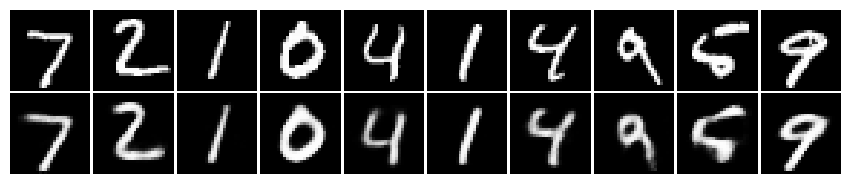

epoch 0 | iter 110 | cost 0.0094
epoch 0 | iter 120 | cost 0.0089
epoch 0 | iter 130 | cost 0.0080
epoch 0 | iter 140 | cost 0.0096
epoch 0 | iter 150 | cost 0.0102


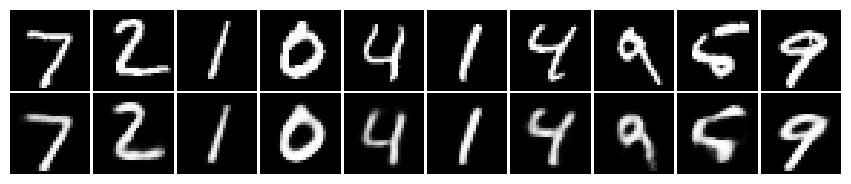

epoch 0 | iter 160 | cost 0.0103
epoch 0 | iter 170 | cost 0.0089
epoch 0 | iter 180 | cost 0.0083
epoch 0 | iter 190 | cost 0.0091
epoch 0 | iter 200 | cost 0.0095


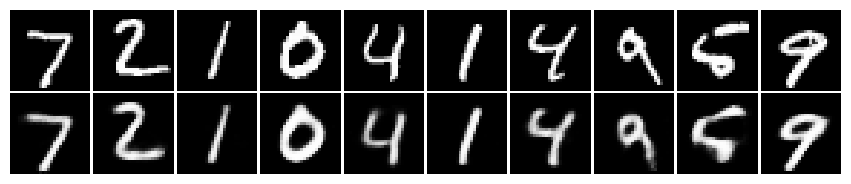

epoch 0 | iter 210 | cost 0.0100
epoch 0 | iter 220 | cost 0.0082
epoch 0 | iter 230 | cost 0.0098
epoch 0 | iter 240 | cost 0.0112
epoch 0 | iter 250 | cost 0.0085


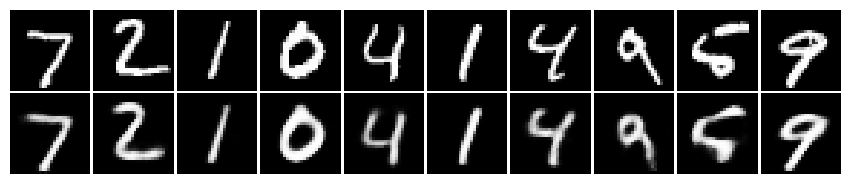

epoch 0 | iter 260 | cost 0.0099
epoch 0 | iter 270 | cost 0.0100
epoch 0 | iter 280 | cost 0.0093
epoch 0 | iter 290 | cost 0.0098
epoch 0 | iter 300 | cost 0.0072


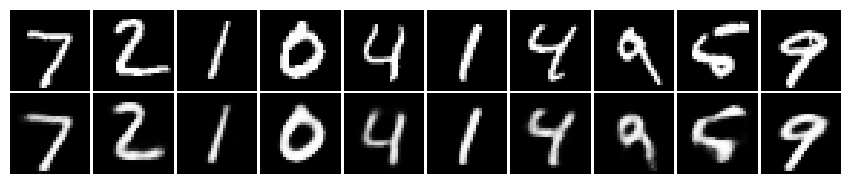

epoch 0 | iter 310 | cost 0.0102
epoch 0 | iter 320 | cost 0.0087
epoch 0 | iter 330 | cost 0.0112
epoch 0 | iter 340 | cost 0.0090
epoch 0 | iter 350 | cost 0.0091


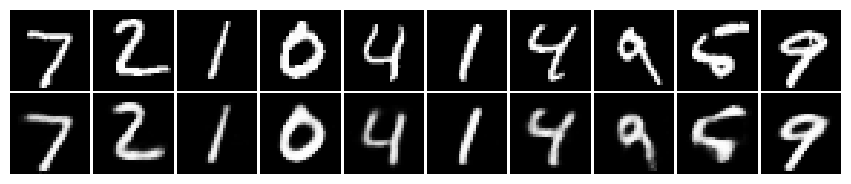

epoch 0 | iter 360 | cost 0.0087
epoch 0 | iter 370 | cost 0.0073
epoch 0 | iter 380 | cost 0.0095
epoch 0 | iter 390 | cost 0.0111
epoch 0 | iter 400 | cost 0.0088


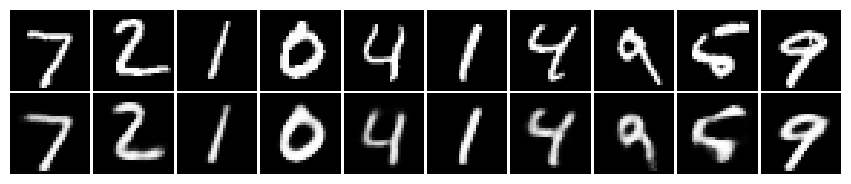

epoch 0 | iter 410 | cost 0.0101
epoch 0 | iter 420 | cost 0.0074
epoch 0 | iter 430 | cost 0.0099
epoch 0 | iter 440 | cost 0.0092
epoch 0 | iter 450 | cost 0.0129


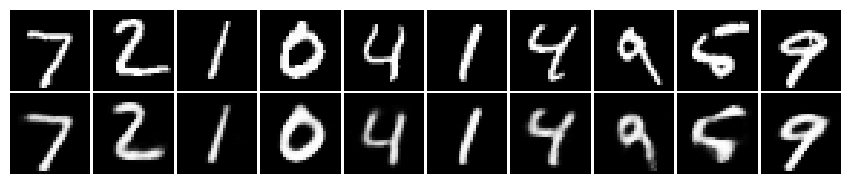

epoch 0 | iter 460 | cost 0.0085
epoch 0 | iter 470 | cost 0.0116
epoch 0 | iter 480 | cost 0.0105
epoch 0 | iter 490 | cost 0.0108


KeyboardInterrupt: 

In [77]:
total_epochs = 1
mse_loss = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr = 0.0001)

LOG_INTERVAL = 10
SUMMARY_INTERVAL = 50

for epoch in range(0,total_epochs):
    for i, (x, y) in enumerate(train_dl):
        optim.zero_grad()
        target = ae(x.to(device)).unsqueeze(1)
        cost = mse_loss(x, target)
        cost.backward()
        optim.step()
        
        if (i%LOG_INTERVAL) == 0:
            print(f"epoch {epoch} | iter {i} | cost {cost:.4f}")        
        
        if (i%SUMMARY_INTERVAL)==0:
            show_summary_1(valid_dl,ae)